#### Correlation between the 2021 Super Bowl and a possible rise in cases of COVID-19

In [1]:
import pandas as pd
from datetime import date, timedelta
import piecewise_regression as pr
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns 
import pymc as pm
import arviz as az
import numpy as np
import scipy.stats as stats
import sdt.changepoint as c
import math
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
file_path = "./covid_confirmed_usafacts.csv"
# Read the CSV file using pandas
dataframe = pd.read_csv(file_path)
#get rid of all the rows with county name = Statewide Unallocated
dataframe = dataframe[dataframe['County Name'] != 'Statewide Unallocated']
#get rid of all the rows with county name = Out of Country
dataframe = dataframe[dataframe['County Name'] != 'Out of Country']

In [3]:
#CREATION OF THE DATAFRAME
# Specify the file path or URL of the CSV file

#restrict the date range to 2021-01-23 to 2021-02-23 but keep state, countyFIPS and StateFIPS
#aggregate by state
grouped = dataframe.groupby('State').sum()
#rename the grouped column as State
grouped = grouped.rename_axis('Date').reset_index()
partGrouped = grouped[["Date"]]
start_date = date(2021, 1, 24) #moving average starts having values on the 24th of January
super_bowl_date = date(2021, 2, 7)
sbplus7_date = date(2021, 2, 14)
sbplus14_date = date(2021, 2, 21)

difference = super_bowl_date - start_date


end_date = date(2021, 3, 7)
final_diff = end_date - start_date
delta = end_date - start_date   # returns timedelta
listdays = []
for i in range(delta.days + 1):
    day = start_date + timedelta(days=i)
    listdays.append(day.strftime("%Y-%m-%d"))
#istdays.insert(0, 'State')
otherGrouped = grouped[listdays]
#join the two dataframes
grouped = pd.concat([partGrouped, otherGrouped], axis=1)
grouped = grouped.T
grouped.columns = grouped.iloc[0]
grouped = grouped.iloc[1: , :]
#grouped.rename(columns = {'State':'Date'}, inplace = True )
grouped.head()

dataframe_list = []
print(grouped.columns)
for col in grouped.columns:
    dataframe_list.append(grouped[[col]])

for d in dataframe_list:
    #add column with difference between current day and previous day
    d['Diff'] = d.diff()
    #add column with moving average of the difference
    d['MAV'] = d['Diff'].rolling(window=7).mean()
    
    #add column with the log of the moving average
    d['Log'] = np.log(d['MAV'])
    d.dropna(inplace=True)
    d.index = pd.to_datetime(d.index)

print(dataframe_list[0])


Index(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
       'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
       'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
       'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
       'WI', 'WV', 'WY'],
      dtype='object', name='Date')
Date           AK  Diff         MAV       Log
2021-01-31  53534    76  132.000000  4.882802
2021-02-01  53654   120  131.571429  4.879550
2021-02-02  53805   151  140.142857  4.942662
2021-02-03  53947   142  146.571429  4.987513
2021-02-04  54154   207  151.285714  5.019170
2021-02-05  54326   172  151.000000  5.017280
2021-02-06  54591   265  161.857143  5.086714
2021-02-07  54683    92  164.142857  5.100737
2021-02-08  54882   199  175.428571  5.167232
2021-02-09  55066   184  180.142857  5.193750
2021-02-10  55135    69  169.714286  5.134116
2021-02-11  55297   162  163.285714  5.095502
2021-02-12  55468   171  

C:\Users\Simone\AppData\Local\Temp\ipykernel_12708\3491405618.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['Diff'] = d.diff()
C:\Users\Simone\AppData\Local\Temp\ipykernel_12708\3491405618.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['MAV'] = d['Diff'].rolling(window=7).mean()
C:\Users\Simone\AppData\Local\Temp\ipykernel_12708\3491405618.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

AK

                    Breakpoint Regression Results                     
No. Observations                       36
No. Model Parameters                    4
Degrees of Freedom                     32
Res. Sum of Squares               1.91511
Total Sum of Squares              2.08264
R Squared                        0.080438
Adjusted R Squared              -0.038215
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const                4.87042        0.167       29.218       1.2e-24       4.5309         5.21
alpha1              0.034418       0.0462      0.74446         0.462    -0.059753      0.12859
beta1             -0.0424943       0.0465     -0.91288             -     -0.13731     0.052324
breakpoint1          5.98223         4.48            -             -      -3.1469       15.111
--------------

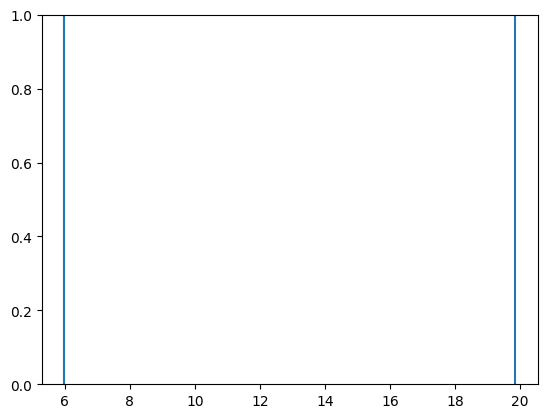

In [26]:
for df in dataframe_list[:2]:
    print(df.columns.values[0])
    y = df['Log'].values
    x = np.arange(len(y))
    pw_fit = pr.Fit(x, y, n_breakpoints=1, start_values=[14.0])
    pw_fit.summary()
    pw_fit.plot_breakpoints()

In [14]:
'''array_results = []
np.seterr(divide = 'ignore') 
for df in dataframe_list[:2]:
    data = df['Log']
    data = data.values.flatten()
    print(data)
    # model with pymc3
    with pm.Model() as model:


        lambda_1 = pm.Normal("lambda_1", mu=0, sigma=1)
        lambda_2 = pm.Normal("lambda_2", mu=0, sigma=1)
        tau = pm.DiscreteUniform("tau", lower=0, upper=len(data) - 1)
        idx = np.arange(len(data))
        lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
        observation = pm.Poisson("obs", lambda_, observed=data)
        step = pm.Metropolis(vars=[lambda_1, lambda_2, tau])
        trace = pm.sample(10000, tune=5000, step=step, return_inferencedata=True)
        array_results.append([df.columns.values[0],trace])
        print("Results for " + df.columns.values[0] + ":")
        print(trace.posterior)
print(array_results)'''

'array_results = []\nnp.seterr(divide = \'ignore\') \nfor df in dataframe_list[:2]:\n    data = df[\'Log\']\n    data = data.values.flatten()\n    print(data)\n    # model with pymc3\n    with pm.Model() as model:\n\n\n        lambda_1 = pm.Normal("lambda_1", mu=0, sigma=1)\n        lambda_2 = pm.Normal("lambda_2", mu=0, sigma=1)\n        tau = pm.DiscreteUniform("tau", lower=0, upper=len(data) - 1)\n        idx = np.arange(len(data))\n        lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)\n        observation = pm.Poisson("obs", lambda_, observed=data)\n        step = pm.Metropolis(vars=[lambda_1, lambda_2, tau])\n        trace = pm.sample(10000, tune=5000, step=step, return_inferencedata=True)\n        array_results.append([df.columns.values[0],trace])\n        print("Results for " + df.columns.values[0] + ":")\n        print(trace.posterior)\nprint(array_results)'

In [15]:
array_results2 = []
for df in dataframe_list[:2]:
    data = df['Log']
    data = data.values.flatten()

    # model with pymc3
    with pm.Model() as model:
        μ = pm.Normal("lambda_1", 0, 1)
        σ = pm.HalfNormal("lambda_2", 1)
        y = pm.Normal("y", μ, σ, observed=data)
        idataC = pm.sample(return_inferencedata=True)
        alpha = 1 / data.mean()
        lambda_1 = pm.Normal("lambda_1", mu=5, sigma=1)
        lambda_2 = pm.Normal("lambda_2", mu=5, sigma=1)
        tau = pm.DiscreteUniform("tau", lower=0, upper=len(data) - 1)
        idx = np.arange(len(data))
        lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
        observation = pm.Poisson("obs", lambda_, observed=data)
        step = pm.Metropolis(random_seed=2)
        trace = pm.sample(10000, tune=5000, step=step, return_inferencedata=True)
        array_results2.append([df.columns.values[0],trace])
        print("Results for " + df.columns.values[0] + ":")
        print(trace.posterior)
print(array_results2)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 62 seconds.


Results for AK:
<xarray.Dataset>
Dimensions:   (chain: 4, draw: 10000)
Coordinates:
  * chain     (chain) int32 0 1 2 3
  * draw      (draw) int32 0 1 2 3 4 5 6 ... 9993 9994 9995 9996 9997 9998 9999
Data variables:
    lambda_1  (chain, draw) float64 4.7 5.677 4.961 4.961 ... 4.914 4.688 4.688
    lambda_2  (chain, draw) float64 4.85 5.236 5.236 5.236 ... 5.063 4.13 4.13
    tau       (chain, draw) int64 2 2 2 5 5 8 25 25 ... 22 26 27 27 24 24 24 34
Attributes:
    created_at:                 2023-07-04T08:21:17.245956
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.5.0
    sampling_time:              61.52715611457825
    tuning_steps:               5000


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [tau]


ValueError: Not enough samples to build a trace.

In [4]:
def round_half_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n*multiplier + 0.5) / multiplier

In [5]:


media_changepoint = 0.0
count_changepoint = 0.0
min_changepoint = (999,"error")
max_changepoint = (-1,"error")
save_me = []
tabella = pd.DataFrame(columns=['State','Changepoint','FirstSlope','SecondSlope','95 changepoints', '95 first slope', '95 second slope'])

for i in range(len(array_results2)):
    df = dataframe_list[i]
    trace = array_results2[i][1]
    print("Results for " + df.columns.values[0] + ":")
    #plot values for the 'diff' column, changepoints and trend lines before and after the changepoints
    values = df['Log'].values.flatten()
    #find the changepoints indexes
    changepoints = trace.posterior['tau'].values.flatten()
    #find the slopes with their signs
    slopes = trace.posterior['lambda_1'].values.flatten()
    slopes2 = trace.posterior['lambda_2'].values.flatten()



    val = []
    
    #find the mean of the slopes
    mean_slope = np.mean(slopes)
    mean_slope2 = np.mean(slopes2)
    #find the mean of the changepoints
    mean_changepoint = np.mean(changepoints)

    print(mean_changepoint)
    print(mean_slope)
    print(mean_slope2)

    for a in [changepoints, slopes, slopes2]:
        mean = np.mean(a)
        standard_deviation = np.std(a)
        number_of_samples = len(a)

        #calculate the 95% confidence interval
        confidence_interval = 1.96 * (standard_deviation/math.sqrt(number_of_samples))
        lower_bound = mean - confidence_interval
        upper_bound = mean + confidence_interval
        val.append([round_half_up(lower_bound,2), round_half_up(upper_bound,2)])
    #plot the values, the changepoints and the trend lines
    print(round_half_up(mean_changepoint))
    c.plot_changepoints(values, [int(round_half_up(mean_changepoint))], segment_alpha=0.3,segment_colors=['#66ffc2', '#ffb3b3'])
    #plot the lines for the slopes
    #plt.plot(range(0,int(round_half_up(mean_changepoint))), [mean_slope*x for x in range(0,int(round_half_up(mean_changepoint)))], color='red')
    
    i = int(round_half_up(mean_changepoint))
    zed = np.polyfit(range(0,i), values[:i], 1)
    p = np.poly1d(zed)
    zed2 = np.polyfit(range(i,len(values)), values[i:], 1)
    p2 = np.poly1d(zed2)
    plot_out = [[p,np.arange(0,i+1),range(0,i+1),"#116530"],[p2,np.arange(i,len(values)),range(i,len(values)),"#DB3F29"]]
    entry = pd.DataFrame.from_dict({"State": [df.columns.values[0]],'Changepoint': [i],'FirstSlope': [round_half_up(mean_slope)],'SecondSlope': [round_half_up(mean_slope2)], "95 changepoints":[val[0]], "95 first slope":[val[1]], "95 second slope":[val[2]]})
    tabella = pd.concat([tabella, entry], ignore_index=True)
    #plot a line from the start to the changepoint with slope mean_slope that intercepts the first point of the changepoint
    

    
    for p in plot_out:
        plt.plot(p[1], p[0](p[2]), color=p[3], linewidth=2, linestyle="dashdot")
    
    plt.title(df.columns.values[0] )#+ " | Threshold of " + str(prob))
    plt.axvline(x = difference.days, color = 'green', label = 'Super Bowl')
    plt.axvline(x = difference.days+7, color="#D7A449", label = 'Super Bowl')
    plt.axvline(x = difference.days+14, color = 'red', label = 'Super Bowl')
    plt.xlabel("Days since the 24th of January 2021")
    plt.ylabel("Current MA - Previous MA")
    #save the plot as a png file
    plt.savefig("./pictures/"+df.columns.values[0] +"_true"+".png")
    plt.show()

tabella.to_csv("./tabella3.csv", index=False)

    
    #plot values for the 'diff' column, changepoints and trend lines before and after the changepoints


NameError: name 'array_results2' is not defined

[32]
 
-0.01301 x + 149.2   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]   range(0, 33)   #116530
 
-5.2 x + 295.2   [32 33 34 35]   range(32, 36)   #DB3F29


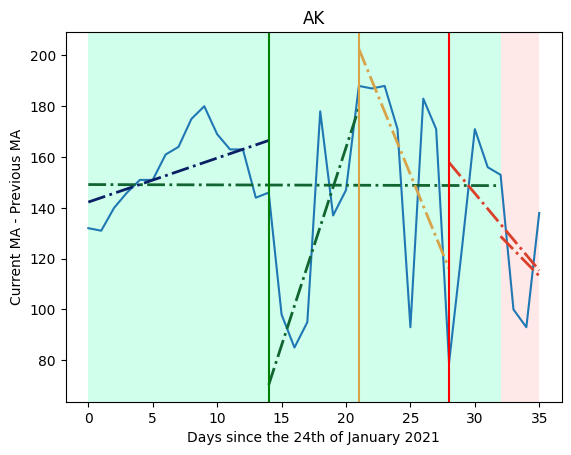

[13]
 
-107.9 x + 2637   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]   range(0, 14)   #116530
 
-8.367 x + 1178   [13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35]   range(13, 36)   #DB3F29


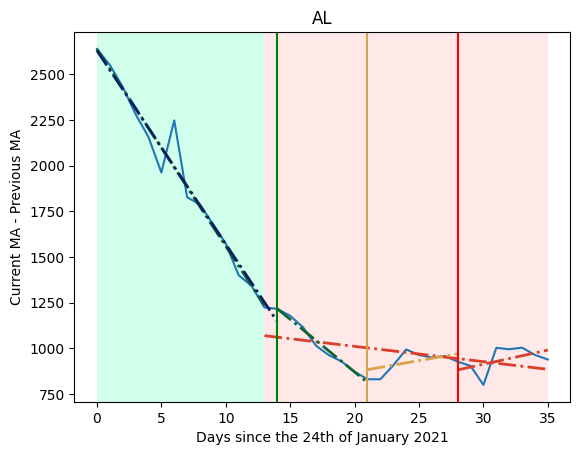

[13]
 
-42.1 x + 1777   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]   range(0, 14)   #116530
 
-0.8923 x + 655.9   [13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35]   range(13, 36)   #DB3F29


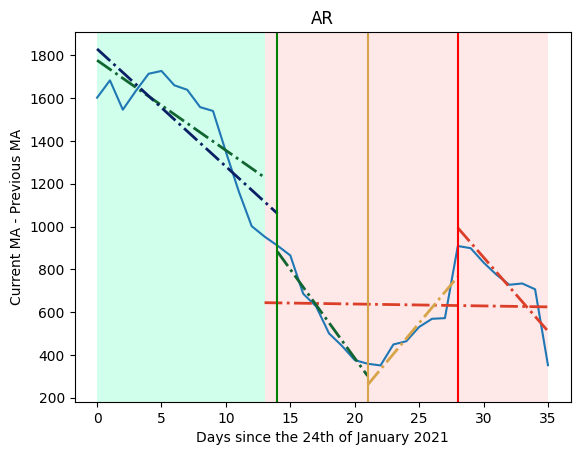

[15]
 
-198 x + 4911   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]   range(0, 16)   #116530
 
-12.59 x + 1773   [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35]   range(15, 36)   #DB3F29


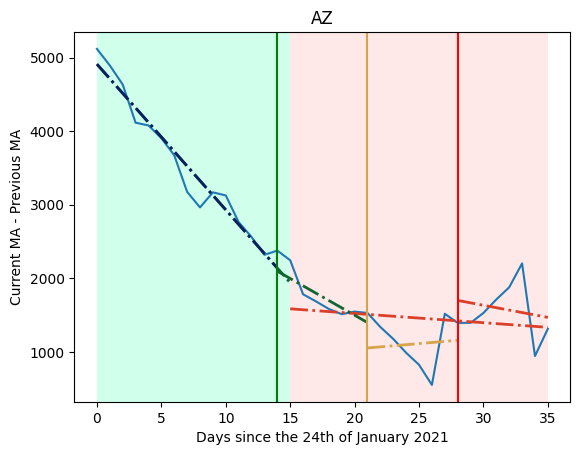

[17]
 
-554.8 x + 1.437e+04   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]   range(0, 18)   #116530
 
-138 x + 7470   [17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35]   range(17, 36)   #DB3F29


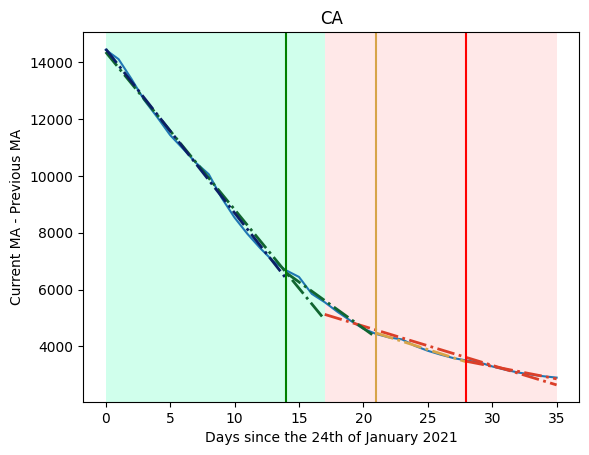

[14]
 
-1.829 x + 1322   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]   range(0, 15)   #116530
 
4.523 x + 998.6   [14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35]   range(14, 36)   #DB3F29


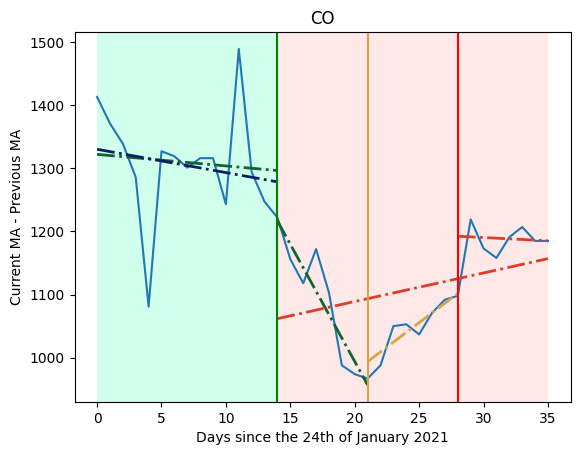

KeyboardInterrupt: 

In [11]:


BayesOffline = c.BayesOffline()
media_changepoint = 0.0
count_changepoint = 0.0
min_changepoint = (999,"error")
max_changepoint = (-1,"error")
save_me = []
tabella = pd.DataFrame(columns=['State','FirstSlope','SecondSlope','when'])
for df in dataframe_list:
    df = df.astype(int)
    values = df[df.columns.values[2]].values

    mean = np.mean(values)
    standard_deviation = np.std(values)
    number_of_samples = len(values)

    #calculate the 95% confidence interval
    confidence_interval = 1.96 * (standard_deviation/math.sqrt(number_of_samples))
    lower_bound = mean - confidence_interval
    upper_bound = mean + confidence_interval

    df2 = df[df.columns.values[2]]
    values_before = df2.iloc[:difference.days+1].values
    values_oneWeek = df2.iloc[difference.days+1:difference.days+8].values
    values_twoWeek = df2.iloc[difference.days+8:difference.days+15].values
    values_after = df2.iloc[difference.days+15:].values

    # Out is a list of possible changepoint "indices"
    prob = 0.9
    out = []
    
    plot_out = []
    while len(out) == 0:
        prob = prob * 0.9
        out = BayesOffline.find_changepoints(values, prob_threshold=prob)
    print(out)
    for i in out:
        media_changepoint += i
        count_changepoint += 1
        #find minimum and maximum of the changepoints with their state
        if i < min_changepoint[0]:
            min_changepoint = (i,df.columns.values[0])
        if i > max_changepoint[0]:
            max_changepoint = (i,df.columns.values[0])
        save_me.append((i,df.columns.values[0]))
        

        
    if len(out) == 1:
        i = out[0]
        zed = np.polyfit(range(0,i), values[:i], 1)
        p = np.poly1d(zed)
        zed2 = np.polyfit(range(i,len(values)), values[i:], 1)
        p2 = np.poly1d(zed2)
        plot_out = [[p,np.arange(0,i+1),range(0,i+1),"#116530"],[p2,np.arange(i,len(values)),range(i,len(values)),"#DB3F29"]]
        entry = pd.DataFrame.from_dict({"State": [df.columns.values[0]],'FirstSlope': [zed[0]],'SecondSlope': [zed2[0]],'when': [out[0]]})
    else:
        #plot three trends from two changepoints
        i = out[0]
        j = out[1]
        zed = np.polyfit(range(0,i), values[:i], 1)
        p = np.poly1d(zed)
        zed2 = np.polyfit(range(i,j), values[i:j], 1)
        p2 = np.poly1d(zed2)
        zed3 = np.polyfit(range(j,len(values)), values[j:], 1)
        p3 = np.poly1d(zed3)
        plot_out = [[p,np.arange(0,i+1),range(0,i+1),"#116530"],[p2,np.arange(i,j+1),range(i,j+1),"#D7A449"],[p3,np.arange(j,len(values)),range(j,len(values)),"#DB3F29"]]
        entry = pd.DataFrame.from_dict({"State": [df.columns.values[0]],'FirstSlope': [round_half_up(zed[0])],'SecondSlope': [round_half_up(zed2[0])],'ThirdSlope': [zed3[0]]})
    # Plot the data.
    c.plot_changepoints(values, out, segment_alpha=0.3,segment_colors=['#66ffc2', '#ffb3b3'])



    z1 = np.polyfit(range(0,len(values_before)), values_before, 1)
    #print ("{0}x + {1}".format(*z1))
    p1 = np.poly1d(z1)
    z2 = np.polyfit(range(len(values_before),len(values_before)+len(values_oneWeek)), values_oneWeek, 1)
    p2 = np.poly1d(z2)
    z3 = np.polyfit(range(len(values_before)+len(values_oneWeek),len(values_before)+len(values_oneWeek)+len(values_twoWeek)), values_twoWeek, 1)
    p3 = np.poly1d(z3)
    z4 = np.polyfit(range(len(values_before)+len(values_oneWeek)+len(values_twoWeek),len(values_before)+len(values_oneWeek)+len(values_twoWeek)+len(values_after)), values_after, 1)
    p4 = np.poly1d(z4)
    
    #entry = pd.DataFrame.from_dict({"State": [df.columns.values[0]],'FirstSlope': [z1[0]],'SecondSlope': [z2[0]],'ThirdSlope': [z3[0]],'FourthSlope': [z4[0]]})
    #tabella = pd.concat([tabella, entry], ignore_index=True)

    array1 = np.arange(0,len(values_before))
    array2 = np.arange(len(values_before),len(values_before)+len(values_oneWeek))
    array2 = np.insert(array2, 0, array1[-1])
    array3 = np.arange(len(values_before)+len(values_oneWeek),len(values_before)+len(values_oneWeek)+len(values_twoWeek))
    array3 = np.insert(array3, 0, array2[-1])
    array4 = np.arange(len(values_before)+len(values_oneWeek)+len(values_twoWeek),len(values_before)+len(values_oneWeek)+len(values_twoWeek)+len(values_after))
    array4 = np.insert(array4, 0, array3[-1])
    lw = 2
    tabella = pd.concat([tabella, entry], ignore_index=True)
    for p in plot_out:
        print(p[0]," ", p[1], " ", p[2], " ", p[3])
        plt.plot(p[1], p[0](p[2]), color=p[3], linewidth=lw, linestyle="dashdot")
    
    

    '''plt.plot(array1, p1(range(0,len(values_before))), color="#0B1F65", linewidth=lw, linestyle="dashdot")
    plt.plot(array2, p2(range(len(values_before)-1,len(values_before)+len(values_oneWeek))), color="#116530", linewidth=lw, linestyle="dashdot")
    #plt.plot(hole2,)
    plt.plot(array3, p3(range(len(values_before)+len(values_oneWeek)-1,len(values_before)+len(values_oneWeek)+len(values_twoWeek))), color="#D7A449", linewidth=lw, linestyle="dashdot")
    plt.plot(array4, p4(range(len(values_before)+len(values_oneWeek)+len(values_twoWeek)-1,len(values_before)+len(values_oneWeek)+len(values_twoWeek)+len(values_after))), color="#DB3F29", linewidth=lw, linestyle="dashdot")
'''
    

    #plt.plot(values)
    plt.title(df.columns.values[0] )#+ " | Threshold of " + str(prob))
    plt.axvline(x = difference.days, color = 'green', label = 'Super Bowl')
    plt.axvline(x = difference.days+7, color="#D7A449", label = 'Super Bowl')
    plt.axvline(x = difference.days+14, color = 'red', label = 'Super Bowl')
    plt.xlabel("Days since the 24th of January 2021")
    plt.ylabel("Current MA - Previous MA")
    #save the plot as a png file
    plt.savefig("./pictures/"+df.columns.values[0] + "_changepoint" +".png")
    plt.show()
print("Media: " + str(media_changepoint/count_changepoint))
print("Count: " + str(count_changepoint))
print("Difference: " + str(difference.days))
print("Minimum: " + str(min_changepoint))
print("Maximum: " + str(max_changepoint))

with open('a.txt', 'w') as file:
    for a in save_me:
        file.write(str(a[0]) + "," + str(a[1]) +"\n")

In [40]:
#
tabella.set_index(tabella['State'])
#tabella.drop(columns=['State'], inplace=True)
#tabella = tabella.astype({tabella.columns.values[1]: 'string', tabella.columns.values[2]: 'int', tabella.columns.values[3]: 'int'})
print(tabella.head())
tabella.to_csv("./tabella2.csv", index=False)

  State  FirstSlope  SecondSlope when
0    AK   -0.013013    -5.200000   32
1    AL -107.868132    -8.366601   13
2    AR  -42.098901    -0.892292   13
3    AZ -198.035714   -12.585714   15
4    CA -554.794118  -138.042105   17
